# UBER Pickups 

## Project 🚧

One of the main pain point that Uber's team found is that sometimes drivers are not around when users need them. For example, a user might be in San Francisco's Financial District whereas Uber drivers are looking for customers in Castro.  

(If you are not familiar with the bay area, check out <a href="https://www.google.com/maps/place/San+Francisco,+CA,+USA/@37.7515389,-122.4567213,13.43z/data=!4m5!3m4!1s0x80859a6d00690021:0x4a501367f076adff!8m2!3d37.7749295!4d-122.4194155" target="_blank">Google Maps</a>)

Eventhough both neighborhood are not that far away, users would still have to wait 10 to 15 minutes before being picked-up, which is too long. Uber's research shows that users accept to wait 5-7 minutes, otherwise they would cancel their ride. 

Therefore, Uber's data team would like to work on a project where **their app would recommend hot-zones in major cities to be in at any given time of day.**  

## Goals 🎯

Uber already has data about pickups in major cities. Your objective is to create algorithms that will determine where are the hot-zones that drivers should be in. Therefore you will:

* Create an algorithm to find hot zones 
* Visualize results on a nice dashboard 

## Scope of this project 🖼️

To start off, Uber wants to try this feature in New York city. Therefore you will only focus on this city. Data can be found here: 

👉👉<a href="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip" target="_blank"> Uber Trip Data</a> 👈👈

**You only need to focus on New York City for this project**

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Clustering is your friend 

Clustering technics are a perfect fit for the job. Think about it, all the pickup locations can be gathered into different clusters. You can then use **cluster coordinates to pin hot zones** 😉
    

### Create maps with `plotly` 

Check out <a href="https://plotly.com/" target="_blank">Plotly</a> documentation, you can create maps and populate them easily. Obviously, there are other libraries but this one should do the job pretty well. 


### Start small grow big 

Eventhough Uber wants to have hot-zones per hour and per day of week, you should first **start small**. Pick one day at a given hour and **then start to generalize** your approach. 

## Deliverable 📬

To complete this project, your team should: 

* Have a map with hot-zones using any python library (`plotly` or anything else). 
* You should **at least** describe hot-zones per day of week. 
* Compare results with **at least** two unsupervised algorithms like KMeans and DBScan. 

Your maps should look something like this: 

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/Clusters_uber_pickups.png" alt="Uber Cluster Map" />

## Code

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import plotly.express as px
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [2]:
zones = pd.read_csv('./sample_data/taxi-zone-lookup.csv')
zones.sample(5)

LocationID        Borough            Zone
186         187  Staten Island   Port Richmond
261         262      Manhattan  Yorkville East
152         153      Manhattan     Marble Hill
15           16         Queens         Bayside
18           19         Queens       Bellerose

### EDA Zones

In [3]:
zones['Borough'].value_counts()

Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
Unknown           2
EWR               1
Name: Borough, dtype: int64

In [4]:
nb_zones = zones['Borough'].value_counts().count()
print(f'There are {nb_zones} neighborhoods')

There are 7 neighborhoods


In [5]:
april = pd.read_csv('./sample_data/uber-raw-data-apr14.csv')
april.head(5)

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [6]:
april.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


In [7]:
april.Base.value_counts()

B02682    227808
B02598    183263
B02617    108001
B02512     35536
B02764      9908
Name: Base, dtype: int64

In [8]:
april.isna().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

### Create new features from the datetime

In [9]:
april['date'] = pd.to_datetime(april['Date/Time'])
april['day'] = april['date'].dt.day
april['time_hour'] = april['date'].dt.hour
april['time_mins'] = april['date'].dt.minute
april['dayofweek'] = april['date'].dt.dayofweek
april['dayname'] = april['date'].dt.day_name()
april.head(5)

Date/Time      Lat      Lon    Base                date  day  \
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512 2014-04-01 00:11:00    1   
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512 2014-04-01 00:17:00    1   
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512 2014-04-01 00:21:00    1   
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512 2014-04-01 00:28:00    1   
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512 2014-04-01 00:33:00    1   

   time_hour  time_mins  dayofweek  dayname  
0          0         11          1  Tuesday  
1          0         17          1  Tuesday  
2          0         21          1  Tuesday  
3          0         28          1  Tuesday  
4          0         33          1  Tuesday

In [10]:
print(f'Number of pickups per day')
total_pickups = april.shape[0]
pd.DataFrame({'pickups':april['dayname'].value_counts().sort_values(ascending=False),
              '% pickups':april['dayname'].value_counts().sort_values(ascending=False) * 100 / total_pickups})

Number of pickups per day


pickups  % pickups
Wednesday   108631  19.243210
Tuesday      91185  16.152775
Friday       90303  15.996535
Thursday     85067  15.069015
Saturday     77218  13.678620
Monday       60861  10.781094
Sunday       51251   9.078751

### Plot pickups distribution

In [11]:
weekend_days = ['Friday','Saturday', 'Sunday']
weekends = april[april['dayname'].isin(weekend_days)]
workdays = april[~april['dayname'].isin(weekend_days)]

In [12]:
def plot_distribution_day(data, title="Distribution during the day"):
    plt.figure(figsize=(8, 6))
    sns.displot(data=data, x='time_hour', hue='dayname', kind='kde' )
    plt.title(title)
    plt.show()

In [13]:
def plot_distribution_day(data, title="Distribution during the day"):
    plt.figure(figsize=(8, 6))
    sns.displot(data=data, x='time_hour', hue='dayname', kind='kde' )
    plt.title(title)
    plt.show()

<Figure size 576x432 with 0 Axes>

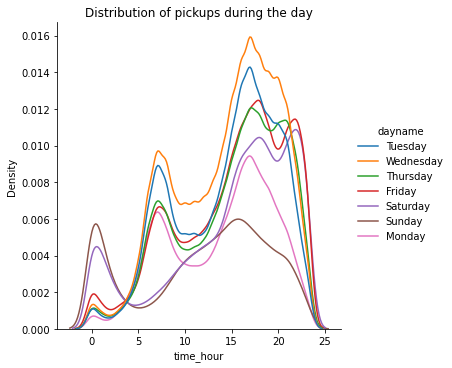

In [14]:
plot_distribution_day(april, title="Distribution of pickups during the day")


> Top 3 days with more pickups: Wednesday, Tuesday, Thursday/Friday

> Day with the least pickups: Sunday

> Pick hours:
- Around 5pm
- Around 7am
- Around midnight


#### Plot Sunday pickups at 0, 7h and 17h

In [15]:
pickups = april[(april['dayname'] == 'Sunday') & (april['time_hour'].isin([0, 7, 17])) ]

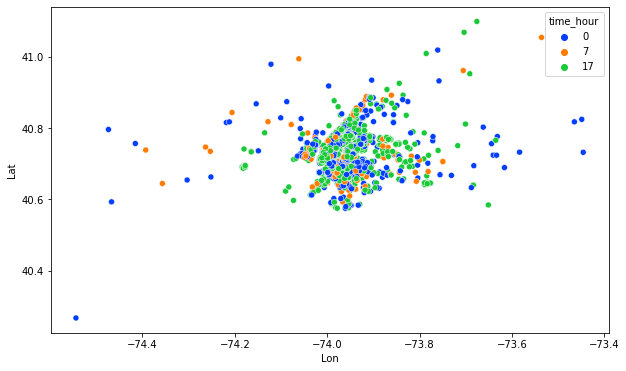

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Lon', y='Lat', data=pickups, hue='time_hour',palette='bright')
#plt.axis('off')
#plt.legend()
plt.show()

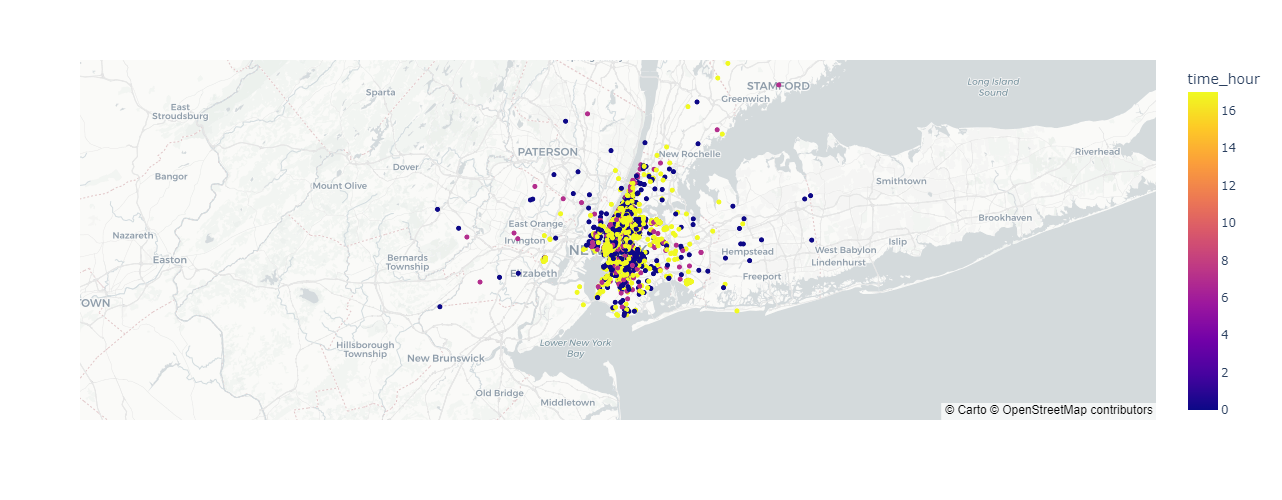

In [17]:
fig = px.scatter_mapbox(pickups, lat="Lat", lon="Lon", color='time_hour', zoom=8, mapbox_style="carto-positron")
fig.update_layout(autosize=False, width=800, height=500)
fig.show()


Without clustering, difficult to see some pattern

### Clustering on Wednesday data

In [18]:
from sklearn.cluster import KMeans

In [19]:
pickups = april[april['dayname'] == 'Wednesday']
X=pickups[['Lat', 'Lon']]

In [20]:
# Baseline: Choose 7 clusters for the 7 neighborhoods 
kmeans =  KMeans(n_clusters= 7, init = "k-means++", random_state = 0)
kmeans.fit(X)
X_clusters = X.copy()
X_clusters['cluster'] = kmeans.predict(X)

#### Cluster centers

In [21]:
kmeans.cluster_centers_

array([[ 40.68845883, -73.96701982],
       [ 40.65700194, -73.78001254],
       [ 40.76446276, -73.97390465],
       [ 40.99525275, -73.64296429],
       [ 40.73135005, -73.99871962],
       [ 40.69753733, -74.21040828],
       [ 40.78866216, -73.880607  ]])

#### Plot in map

In [22]:
def plot_map(X, cluster_column, cluster_centers=None, title='Hot zones'):
    '''
    X: dataframe with Lat et Lon features
    cluster_column: Name of the column containing the cluster
    cluster_centers: Centers of clusters
    '''
    fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color=cluster_column, zoom=8, mapbox_style="carto-positron", title=title)
    if cluster_centers is not None:
        fig.add_trace(go.Scattermapbox(
            lat=cluster_centers[:,0],
            lon=cluster_centers[:, 1],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=12,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            hoverinfo='none',
            showlegend=False,
        ))
    fig.update_layout(autosize=False, width=850, height=500)
    
    fig.show(renderer='jpeg')
    fig.write_image(f"images/{title}.jpeg")

In [23]:
plot_map(X_clusters, 'cluster', cluster_centers=kmeans.cluster_centers_, title='Hot_zones_kmeans_wednesday')

<img src="images/Hot_zones_kmeans_wednesday.jpeg" alt="Hot Zones Kmeans Wednesday" />

#### Train with different number of clusters

In [24]:
def train_kmeans(X, k_init=1, k_end=12):
    wcss =  []
    k = []
    for i in range (k_init,k_end): 
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        k.append(i)
        print("WCSS for K={} --> {}".format(i, wcss[-1]))
    return wcss

In [25]:
wcss = train_kmeans(X)

WCSS for K=1 --> 371.764228550154
WCSS for K=2 --> 234.61205387545144
WCSS for K=3 --> 174.34707670570714
WCSS for K=4 --> 136.6225010112422
WCSS for K=5 --> 104.84046554380112
WCSS for K=6 --> 84.72391540706884
WCSS for K=7 --> 69.0890527119688
WCSS for K=8 --> 59.87065270731725
WCSS for K=9 --> 54.10793621442202
WCSS for K=10 --> 49.23748109263255
WCSS for K=11 --> 44.27406224547113


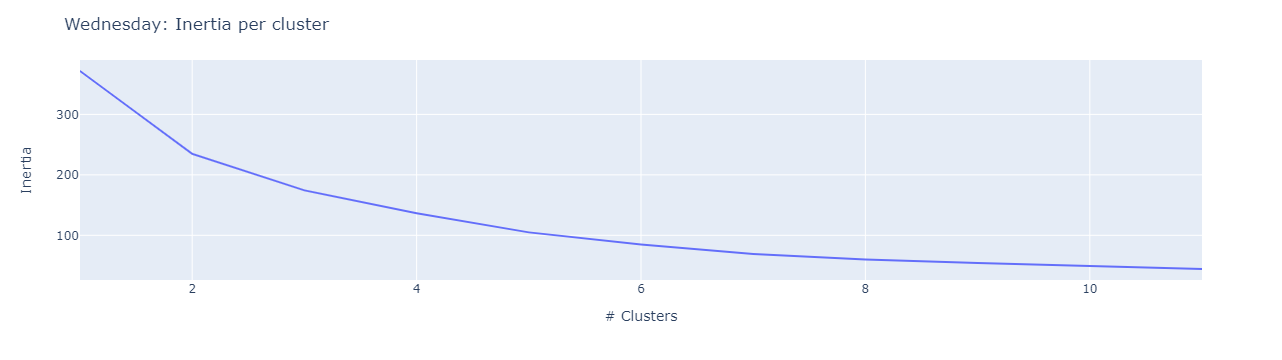

In [26]:
# Let's visualize using plotly
#k=11
# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(range(1, 12))

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Wednesday: Inertia per cluster"
)


> It seems that the "ideal" number of clusters for Wednesday is between 5 and 6

In [27]:
def kmeans_fit_predict(X, n_clusters):
    kmeans =  KMeans(n_clusters= n_clusters, init = "k-means++", random_state = 0)
    kmeans.fit(X)
    X_clusters = X.copy()
    X_clusters['cluster'] = kmeans.predict(X)
    return X_clusters, kmeans.cluster_centers_

In [28]:
print(f'Testing with 5 clusters')
#kmeans =  KMeans(n_clusters= 5, init = "k-means++", random_state = 0)
#kmeans.fit(X)
#X_clusters['cluster'] = kmeans.predict(X)
X_clusters, cluster_centers = kmeans_fit_predict(X, 5)
X_clusters['cluster'].value_counts()

Testing with 5 clusters


2    51693
0    50317
1     3366
4     2445
3      810
Name: cluster, dtype: int64

In [29]:
cluster_centers

array([[ 40.72233946, -73.99399989],
       [ 40.80043188, -73.86852463],
       [ 40.76313678, -73.97523337],
       [ 40.69766864, -74.21028889],
       [ 40.65844519, -73.77873219]])

Wednesday: 5 clusters

Wednesday: 6 clusters
<img src="images/hot_zones_wednesday_kmeans_5_clusters.jpeg" alt="Hot Zones Wednesday KMeans" />

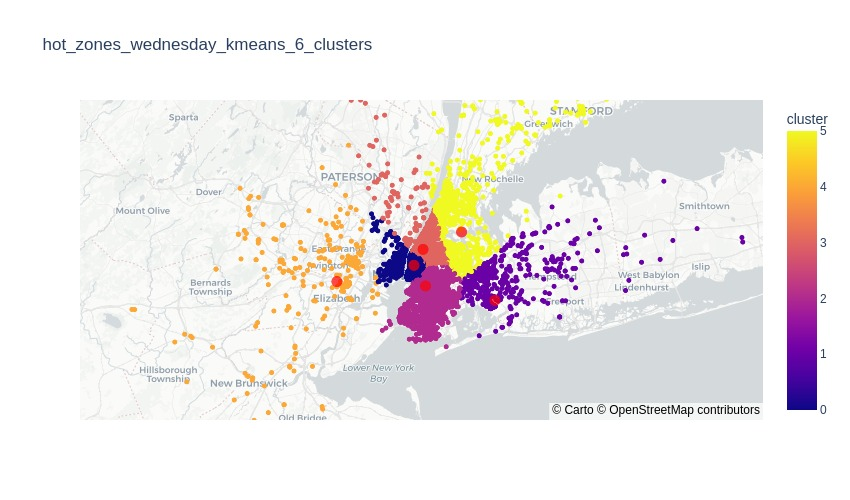

In [30]:
X_clusters, cluster_centers = kmeans_fit_predict(X, 6)
plot_map(X_clusters, 'cluster', cluster_centers, title='hot_zones_wednesday_kmeans_6_clusters')

<img src="images/hot_zones_wednesday_kmeans_6_clusters.jpeg" alt="hot_zones_wednesday_kmeans_6_clusters" />

### Calculate number of clusters (zones) per day

In [31]:
def calculate_elbow_points(X):
    '''
    Calculates elbow points of a dataframe
    '''
    wcss =  []
    k = []
    for i in range (1,11): 
        kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        k.append(i)
        print("WCSS for K={} --> {}".format(i, wcss[-1]))
    return wcss, k    

In [32]:
#from sklearn.metrics import silhouette_score
#silhouette_score(X, kmeans.labels_)

In [33]:
def draw_elbow(wcss, k, day):
    '''
    Parameters:
    -----------------
    wcss: array, list of inertia values
    k:array, list of integer numbers representing the cluster numbers
    day: day of the week 
    '''
    # Create DataFrame
    wcss_frame = pd.DataFrame(wcss)
    k_frame = pd.Series(k)

    # Create figure
    fig= px.line(
        wcss_frame,
        x=k_frame,
        y=wcss_frame.iloc[:,-1]
    )

    # Create title and axis labels
    fig.update_layout(
        yaxis_title="Inertia",
        xaxis_title="# Clusters",
        title=f"Inertia per cluster={day}"
    )

    # Render
    
    fig.show() #renderer="notebook"
    fig.write_image(f"images/kmeans_elbow_{day}.jpeg")
   # fig.show(renderer="iframe") # if using workspace

#### Elbow per day

In [34]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
coords = ['Lat', 'Lon']

WCSS for K=1 --> 283.15338994610624
WCSS for K=2 --> 164.529517822934
WCSS for K=3 --> 126.12654447044336
WCSS for K=4 --> 97.28266025890692
WCSS for K=5 --> 73.93116576347073
WCSS for K=6 --> 57.07806259490142
WCSS for K=7 --> 48.758693014432374
WCSS for K=8 --> 43.53626007714684
WCSS for K=9 --> 38.516840917168224
WCSS for K=10 --> 34.74838260895659


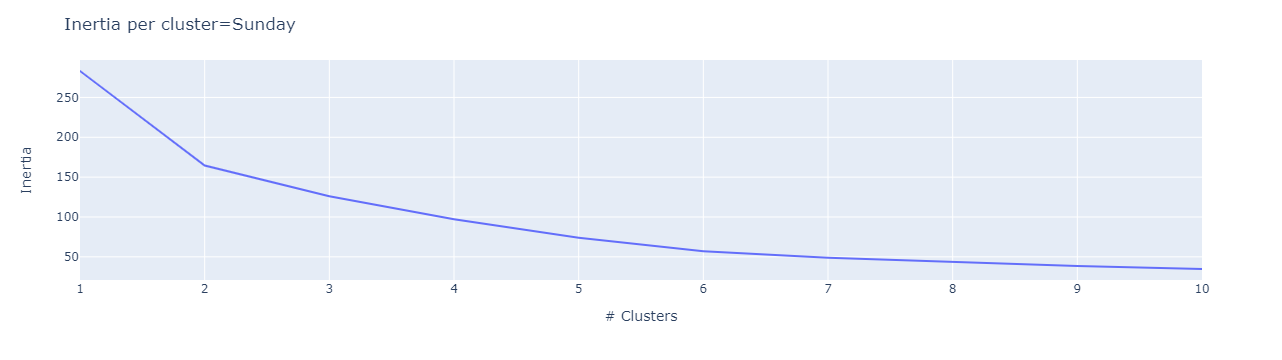

WCSS for K=1 --> 285.0323335822956
WCSS for K=2 --> 163.61565661767926
WCSS for K=3 --> 122.75165353738701
WCSS for K=4 --> 92.47218561979412
WCSS for K=5 --> 67.08683366752943
WCSS for K=6 --> 54.03424088216023
WCSS for K=7 --> 46.681829764782485
WCSS for K=8 --> 39.9351132988157
WCSS for K=9 --> 35.741044635299765
WCSS for K=10 --> 32.52250627904206


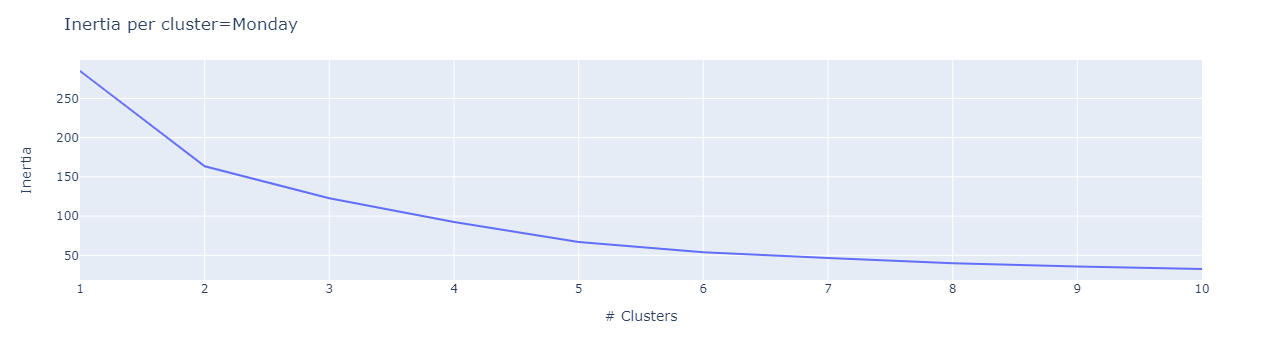

WCSS for K=1 --> 325.80511605649326
WCSS for K=2 --> 203.56031112642242
WCSS for K=3 --> 150.1892604993568
WCSS for K=4 --> 116.12010767612902
WCSS for K=5 --> 87.97747299727494
WCSS for K=6 --> 70.31595806544475
WCSS for K=7 --> 59.219047984448615
WCSS for K=8 --> 51.32449623102592
WCSS for K=9 --> 46.477037181459615
WCSS for K=10 --> 42.26553762260607


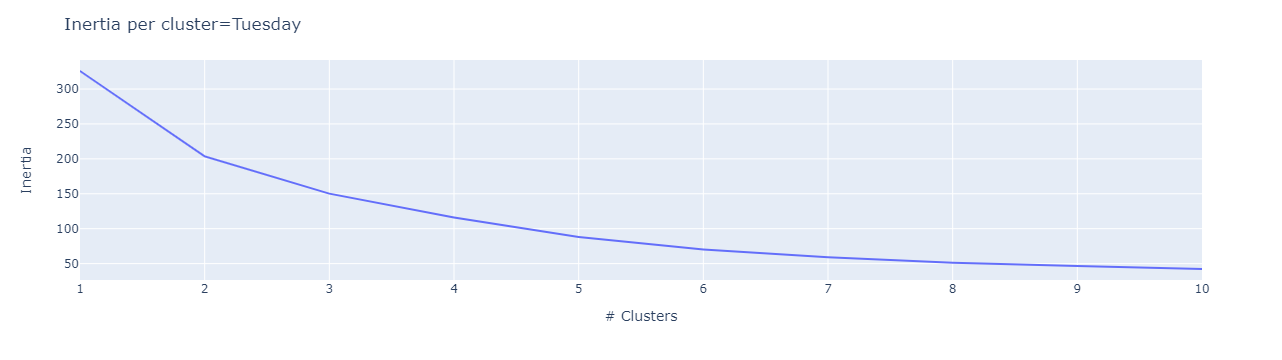

WCSS for K=1 --> 371.764228550154
WCSS for K=2 --> 234.61205387545144
WCSS for K=3 --> 174.34707670570714
WCSS for K=4 --> 136.6225010112422
WCSS for K=5 --> 104.84046554380113
WCSS for K=6 --> 84.72391540706884
WCSS for K=7 --> 69.08905271196879
WCSS for K=8 --> 59.87065270731725
WCSS for K=9 --> 54.107936214422026
WCSS for K=10 --> 49.23748109263255


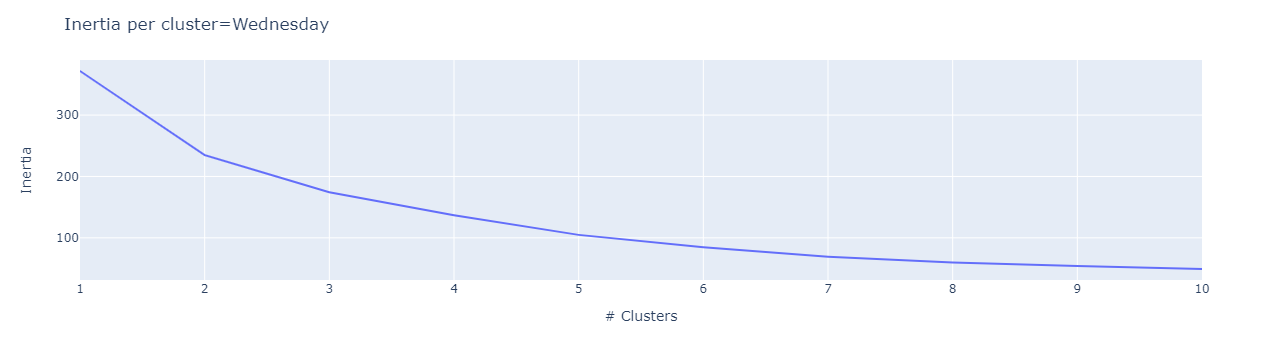

WCSS for K=1 --> 307.95290810626744
WCSS for K=2 --> 192.22189127131344
WCSS for K=3 --> 145.81501194837423
WCSS for K=4 --> 113.46202064138181
WCSS for K=5 --> 86.00555755117001
WCSS for K=6 --> 69.51709492767675
WCSS for K=7 --> 56.52080075861357
WCSS for K=8 --> 49.311555229743455
WCSS for K=9 --> 44.968348743758966
WCSS for K=10 --> 40.903863705938605


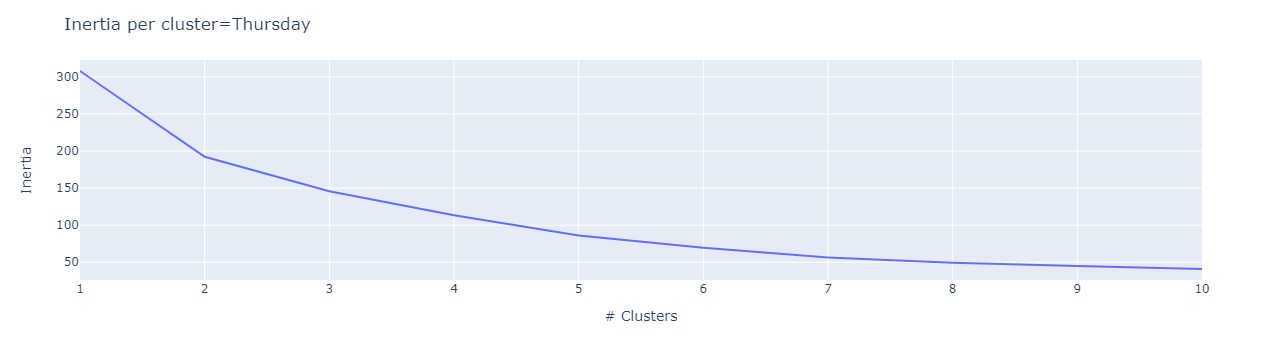

WCSS for K=1 --> 306.76687812187225
WCSS for K=2 --> 198.41654044749737
WCSS for K=3 --> 146.76783970120013
WCSS for K=4 --> 119.25720433875256
WCSS for K=5 --> 96.1281139368913
WCSS for K=6 --> 76.07605569885331
WCSS for K=7 --> 62.90785702750796
WCSS for K=8 --> 55.372079373333996
WCSS for K=9 --> 49.47542409316774
WCSS for K=10 --> 44.61227642159819


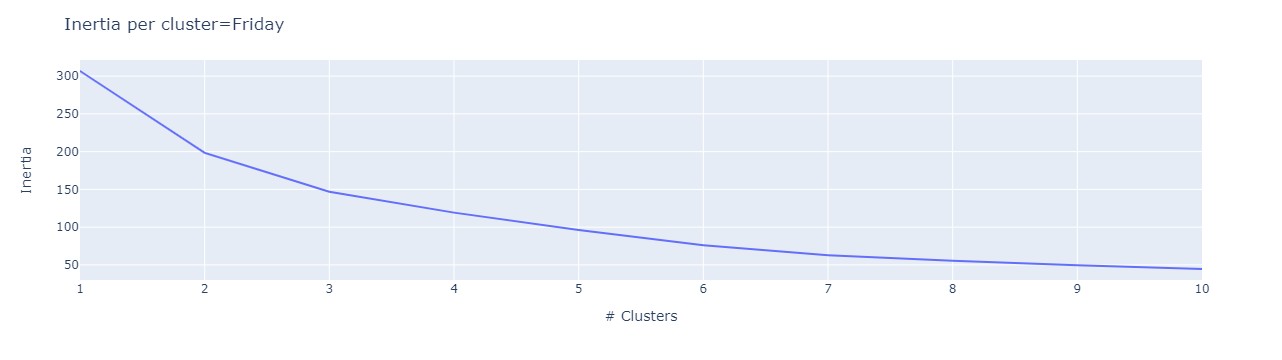

WCSS for K=1 --> 281.8787908052194
WCSS for K=2 --> 192.56324772074012
WCSS for K=3 --> 142.67596341126065
WCSS for K=4 --> 114.68125856313132
WCSS for K=5 --> 95.42182283836588
WCSS for K=6 --> 76.33592130446725
WCSS for K=7 --> 63.117359804106776
WCSS for K=8 --> 55.779683027081774
WCSS for K=9 --> 49.95582917593022
WCSS for K=10 --> 44.71802154123872


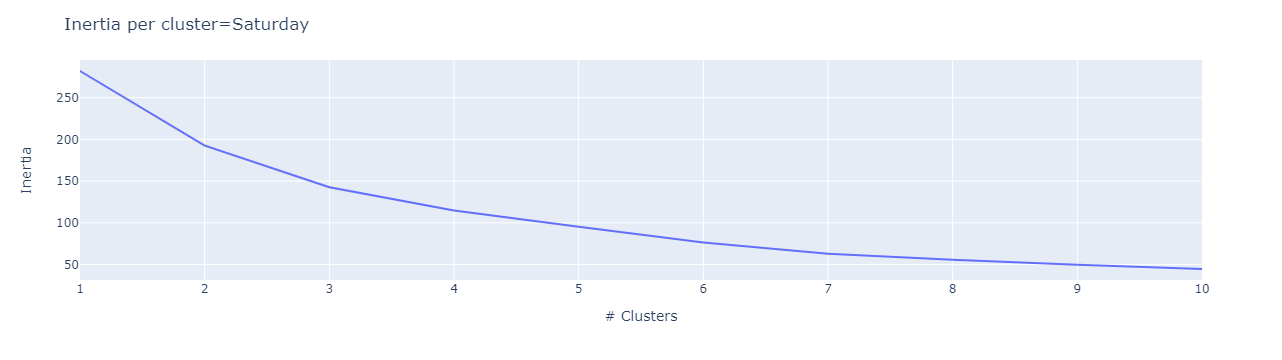

In [35]:
for i, day in enumerate(days):
    wcss, k = calculate_elbow_points(april[april['dayname'] == day].loc[:, coords])
    draw_elbow(wcss, k, day)

### Lets plot some of the days

In [36]:
pickups = april[april['dayname'] == 'Monday']
X=pickups[['Lat', 'Lon']]

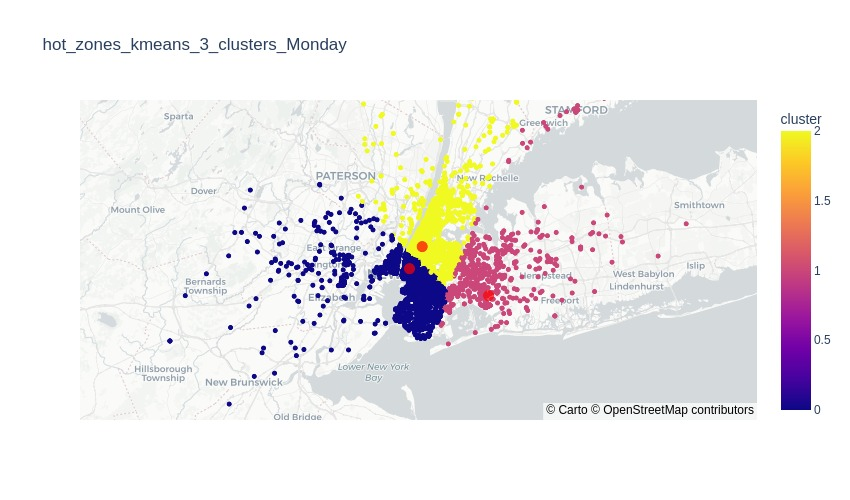

In [37]:
X_clusters, cluster_centers = kmeans_fit_predict(X, 3)
plot_map(X_clusters, 'cluster', cluster_centers, title=f'hot_zones_kmeans_3_clusters_Monday')


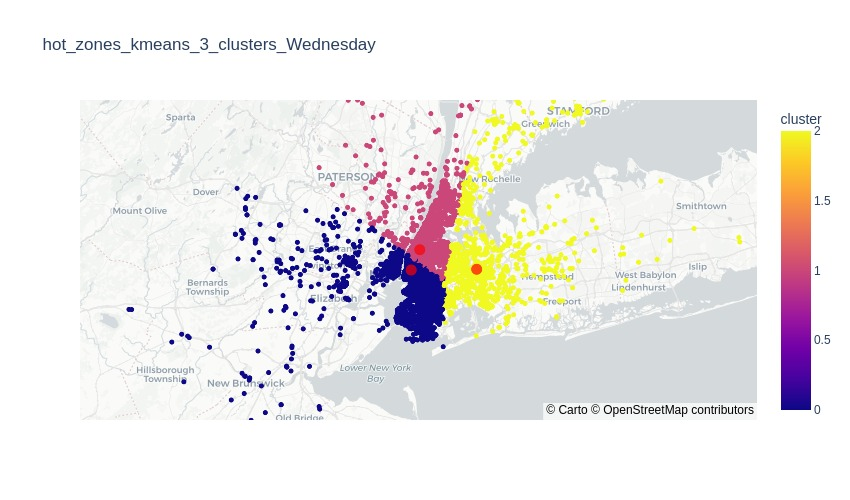

In [38]:
pickups = april[april['dayname'] == 'Wednesday']
X=pickups[['Lat', 'Lon']]
X_clusters, cluster_centers = kmeans_fit_predict(X, 3)
plot_map(X_clusters, 'cluster', cluster_centers, title=f'hot_zones_kmeans_3_clusters_Wednesday')

> Conclusion <br>
Using kmeans, in general, we could determine 3 hot zones.  With the elbow analysis, we can see that from 3 to 4 clusters, there is no much gain in the inertia score. 
It seems that kmeans finds always the same areas and the days don't seem important to find different number of clusters. <br>
One last thing, Kmeans cannot identify outliers, so all points will belong to a zone